## Pre-process CBIS-DDSM dataset

Preprocess the DICOM images.
Pixel arrays are read from DICOM and converted to PNGs, maxinum width and
height of all images are recorded to be used for padding later.
    
adapted from
https://github.com/GoogleCloudPlatform/healthcare/blob/master/datathon/nusdatathon18/scripts/convert_to_tiff.py

In [31]:
import argparse
import math
import multiprocessing
import numpy as np
import pandas as pd
import PIL
import pydicom
import urllib
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Columns to extract from the label files.
BREAST_DENSITY_COL = 'breast density'
IMAGE_FILE_PATH_COL = 'image file path'

In [4]:
PATH = Path("/data2/yinterian/CBIS-DDSM")

In [5]:
path = PATH/"calc_case_description_train_set.csv"
train_calc = pd.read_csv(path)

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...

In [6]:
train_calc[:10]

patient_id  breast density left or right breast image view  abnormality id  \
0    P_00005               3                RIGHT         CC               1   
1    P_00005               3                RIGHT        MLO               1   
2    P_00007               4                 LEFT         CC               1   
3    P_00007               4                 LEFT        MLO               1   
4    P_00008               1                 LEFT         CC               1   
5    P_00008               1                 LEFT         CC               2   
6    P_00008               1                 LEFT         CC               3   
7    P_00008               1                 LEFT        MLO               1   
8    P_00008               1                 LEFT        MLO               2   
9    P_00008               1                 LEFT        MLO               3   

  abnormality type    calc type calc distribution  assessment  \
0    calcification    AMORPHOUS         CLUSTERED           3   
1    calcification    AMORPHOUS         CLUSTERED           3   
2    calcification  PLEOMORPHIC            LINEAR           4   
3    calcification  PLEOMORPHIC            LINEAR           4   
4    calcification          NaN          REGIONAL           2   
5    calcification          NaN          REGIONAL           2   
6    calcification          NaN          REGIONAL           2   
7    calcification          NaN          REGIONAL           2   
8    calcification          NaN          REGIONAL           2   
9    calcification          NaN          REGIONAL           2   

                 pathology  subtlety  \
0                MALIGNANT         3   
1                MALIGNANT         3   
2                   BENIGN         4   
3                   BENIGN         4   
4  BENIGN_WITHOUT_CALLBACK         3   
5  BENIGN_WITHOUT_CALLBACK         3   
6  BENIGN_WITHOUT_CALLBACK         3   
7  BENIGN_WITHOUT_CALLBACK         3   
8  BENIGN_WITHOUT_CALLBACK         3   
9  BENIGN_WITHOUT_CALLBACK         3   

                                     image file path  \
0  Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1  Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2  Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3  Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
5  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
6  Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
7  Calc-Training_P_00008_LEFT_MLO/1.3.6.1.4.1.959...   
8  Calc-Training_P_00008_LEFT_MLO/1.3.6.1.4.1.959...   
9  Calc-Training_P_00008_LEFT_MLO/1.3.6.1.4.1.959...   

                             cropped image file path  \
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...   
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....   
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...   
5  Calc-Training_P_00008_LEFT_CC_2/1.3.6.1.4.1.95...   
6  Calc-Training_P_00008_LEFT_CC_3/1.3.6.1.4.1.95...   
7  Calc-Training_P_00008_LEFT_MLO_1/1.3.6.1.4.1.9...   
8  Calc-Training_P_00008_LEFT_MLO_2/1.3.6.1.4.1.9...   
9  Calc-Training_P_00008_LEFT_MLO_3/1.3.6.1.4.1.9...   

                                  ROI mask file path  
0  Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...  
1  Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....  
2  Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...  
5  Calc-Training_P_00008_LEFT_CC_2/1.3.6.1.4.1.95...  
6  Calc-Training_P_00008_LEFT_CC_3/1.3.6.1.4.1.95...  
7  Calc-Training_P_00008_LEFT_MLO_1/1.3.6.1.4.1.9...  
8  Calc-Training_P_00008_LEFT_MLO_2/1.3.6.1.4.1.9...  
9  Calc-Training_P_00008_LEFT_MLO_3/1.3.6.1.4.1.9...

In [37]:
train_calc.iloc[1, 11]

'Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.427517897311902339923511678883689433338/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/000000.dcm'

In [38]:
train_calc.iloc[1, 12]

'Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.67512362210319636108148504382680781938/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/000001.dcm\n'

In [39]:
train_calc.iloc[1, 13]

'Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1.9590.100.1.2.67512362210319636108148504382680781938/1.3.6.1.4.1.9590.100.1.2.296281207812130400303493285473798422894/000000.dcm'

In [17]:
def get_array_from_dicom(filename):
    filename = filename.strip()
    path = PATH/"CBIS-DDSM"/filename
    dcm = pydicom.dcmread(str(path))
    return dcm.pixel_array

In [49]:
def get_arrays_per_row(i, df=train_calc):
    main_arr = get_array_from_dicom(df.iloc[i, 11])
    crop_arr = get_array_from_dicom(df.iloc[i, 12])
    mask_arr = get_array_from_dicom(df.iloc[i, 13])
    return [main_arr, crop_arr, mask_arr]

In [32]:
def plot_files(arrs):
    N = len(arrs)
    fig, axs = plt.subplots(1, N)
    fig.set_size_inches(14, 5)
    for i in range(N):
        axs[i].imshow(arrs[i])

In [34]:
arrs0 = get_arrays_per_row(0)
arrs1 = get_arrays_per_row(1)

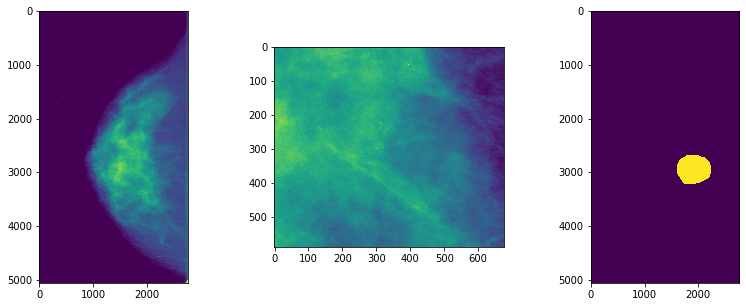

In [35]:
plot_files(arrs0)

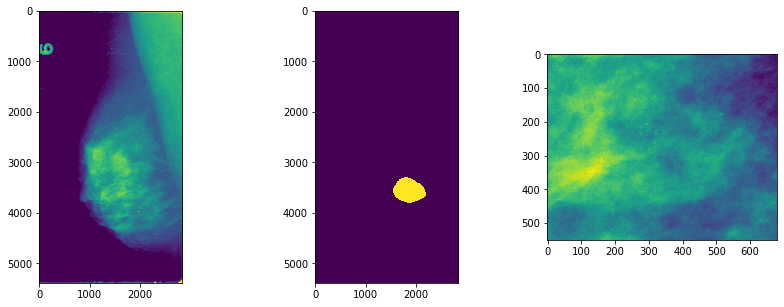

In [36]:
plot_files(arrs1)

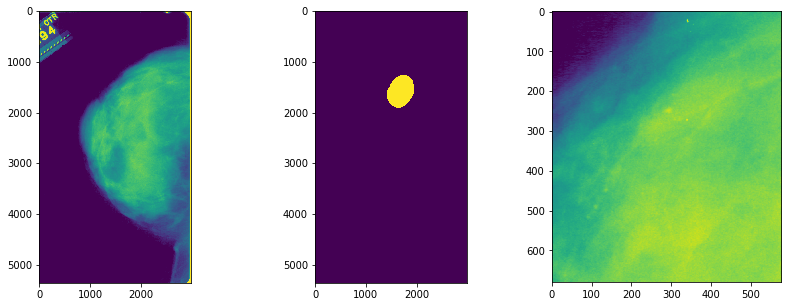

In [41]:
arrsi = get_arrays_per_row(2)
plot_files(arrsi)

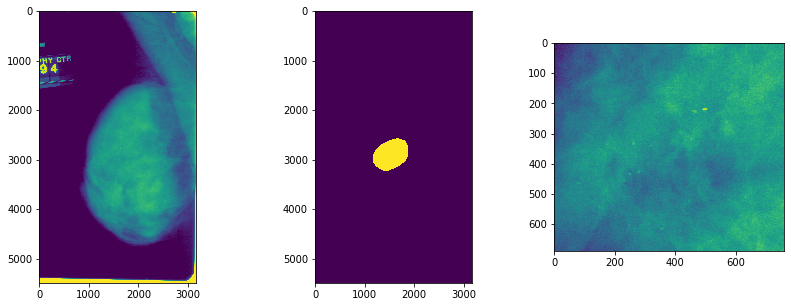

In [42]:
arrsi = get_arrays_per_row(3)
plot_files(arrsi)

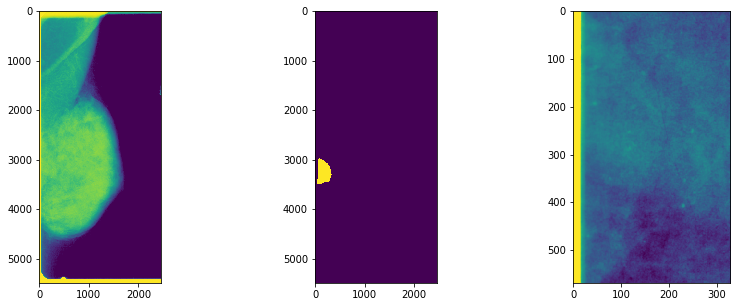

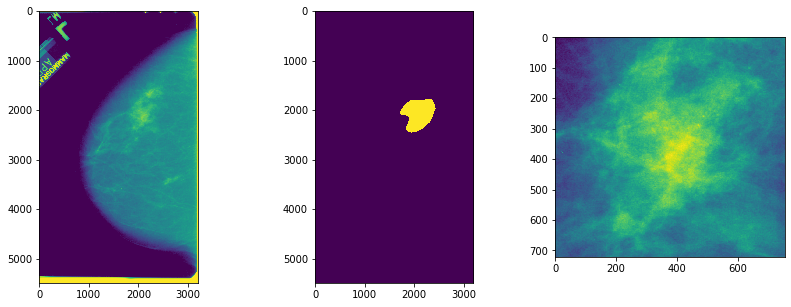

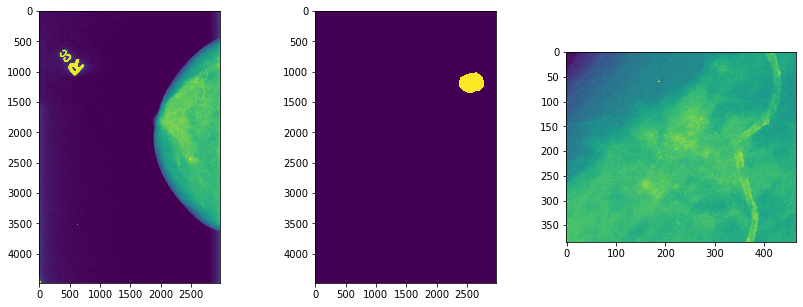

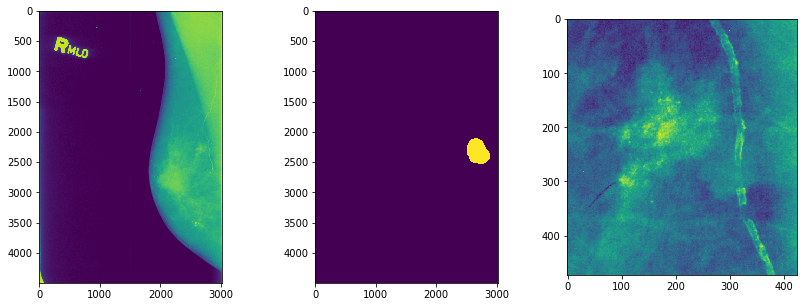

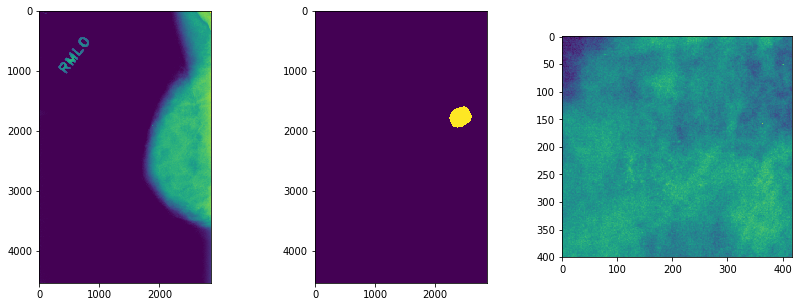

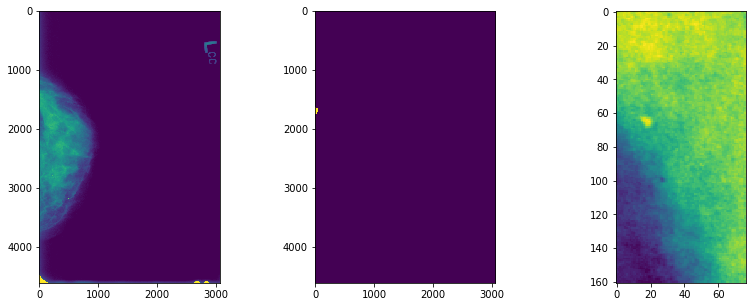

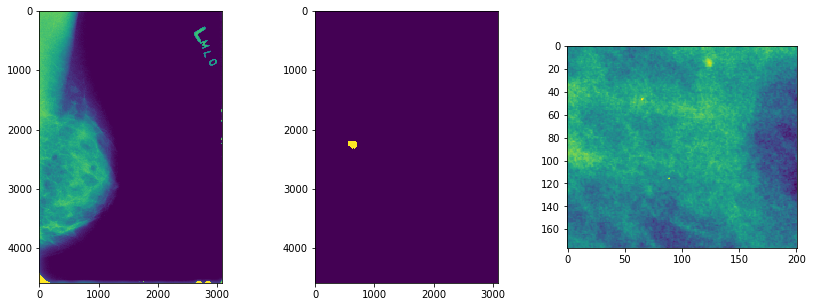

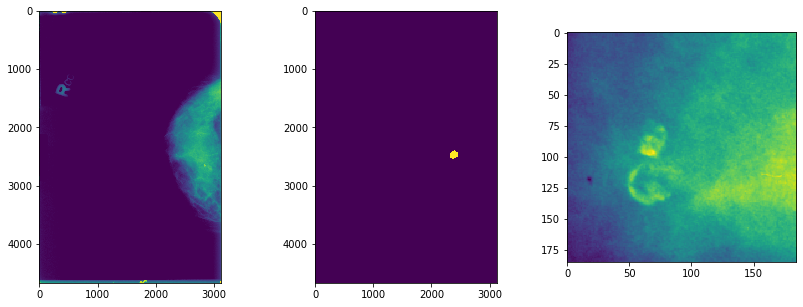

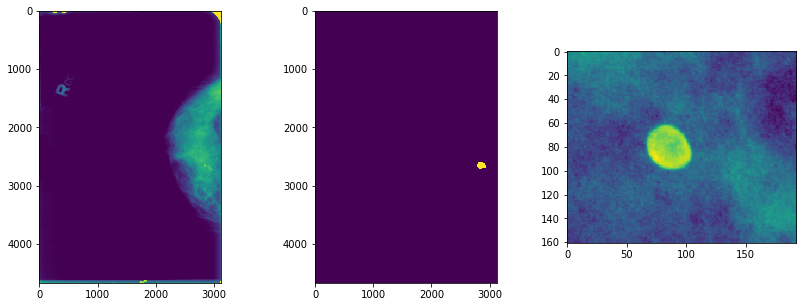

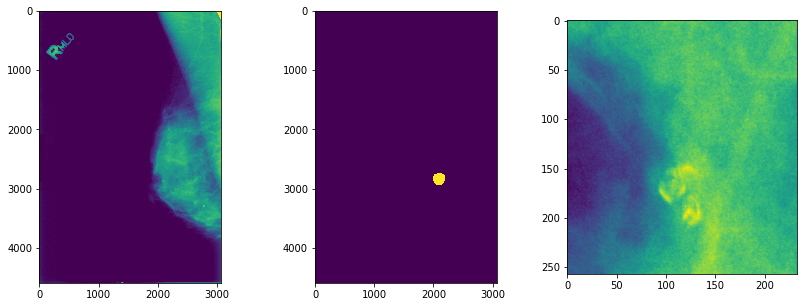

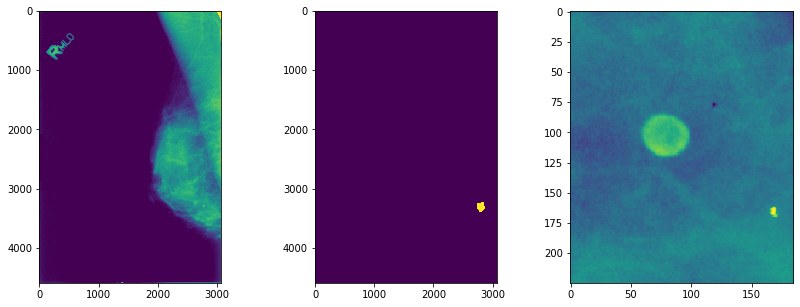

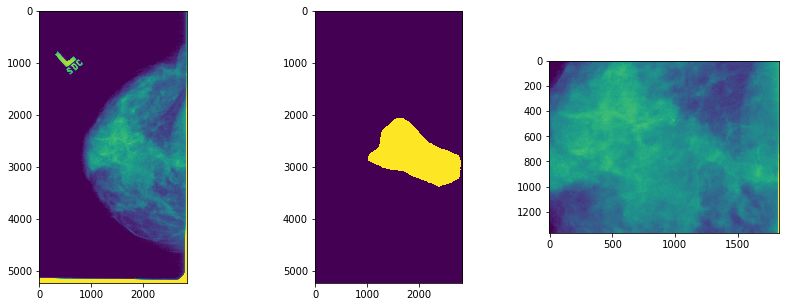

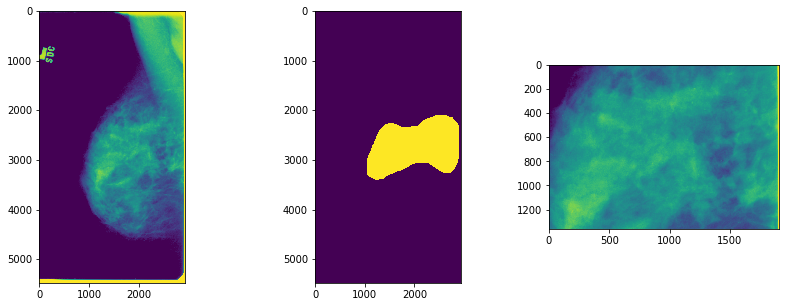

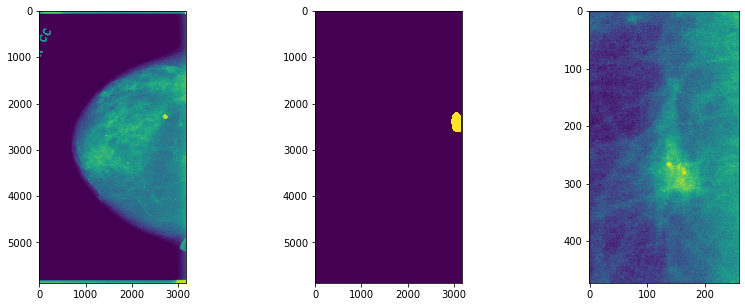

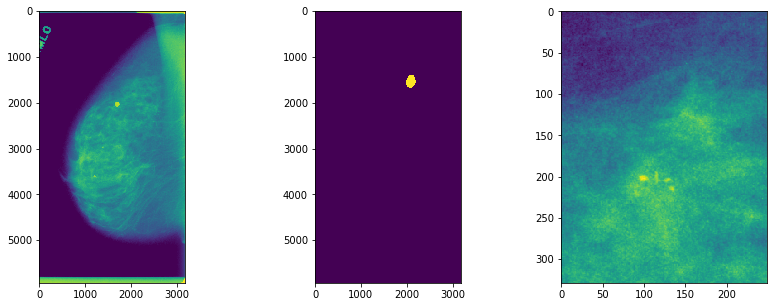

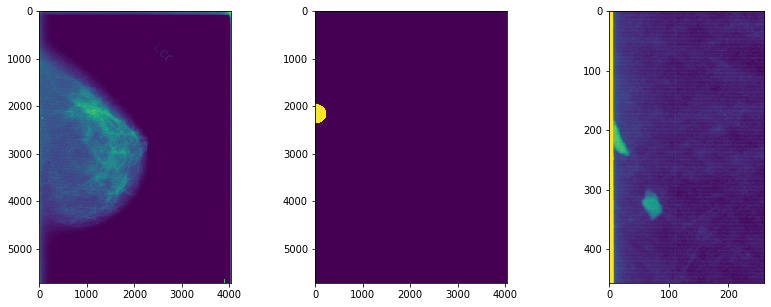

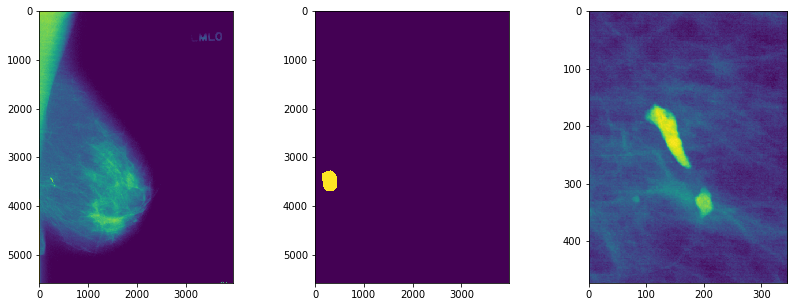

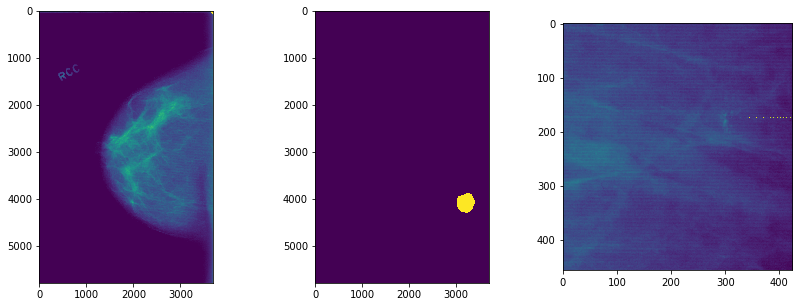

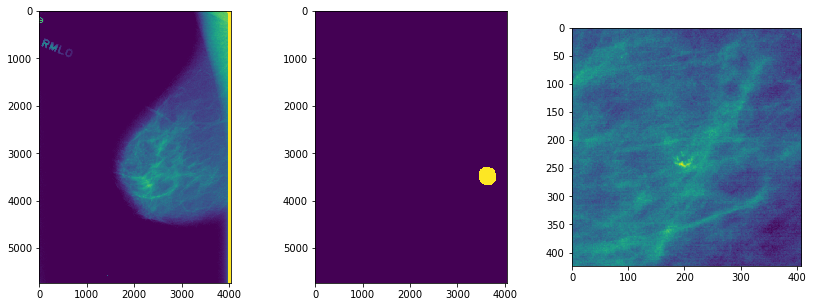

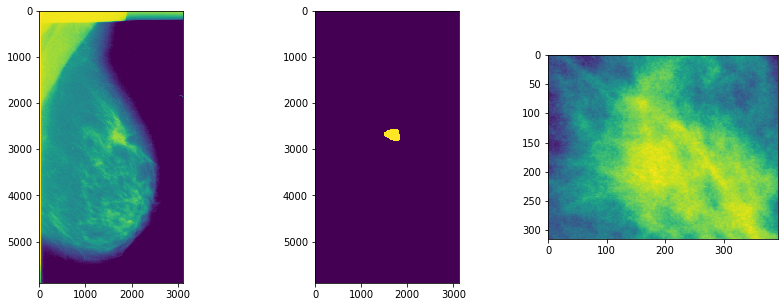

In [46]:
for i in range(500, 520):
    arrsi = get_arrays_per_row(i)
    plot_files(arrsi)

In [47]:
path = PATH/"mass_case_description_train_set.csv"
train_mass = pd.read_csv(path)

In [48]:
train_mass.head()

patient_id  breast_density left or right breast image view  abnormality id  \
0    P_00001               3                 LEFT         CC               1   
1    P_00001               3                 LEFT        MLO               1   
2    P_00004               3                 LEFT         CC               1   
3    P_00004               3                 LEFT        MLO               1   
4    P_00004               3                RIGHT        MLO               1   

  abnormality type                          mass shape   mass margins  \
0             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
1             mass  IRREGULAR-ARCHITECTURAL_DISTORTION     SPICULATED   
2             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
3             mass            ARCHITECTURAL_DISTORTION    ILL_DEFINED   
4             mass                                OVAL  CIRCUMSCRIBED   

   assessment  pathology  subtlety  \
0           4  MALIGNANT         4   
1           4  MALIGNANT         4   
2           4     BENIGN         3   
3           4     BENIGN         3   
4           4     BENIGN         5   

                                     image file path  \
0  Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...   
1  Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...   
2  Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...   
3  Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...   
4  Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...   

                             cropped image file path  \
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...   
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...   
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...   
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...   
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....   

                                  ROI mask file path  
0  Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...  
1  Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...  
2  Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...  
3  Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...  
4  Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....

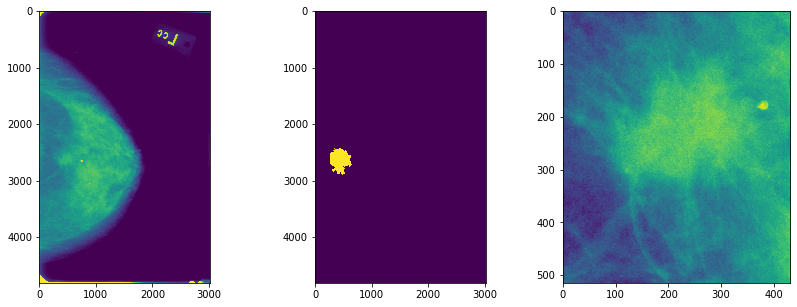

In [50]:
arrs0 = get_arrays_per_row(0, df=train_mass)
plot_files(arrs0)

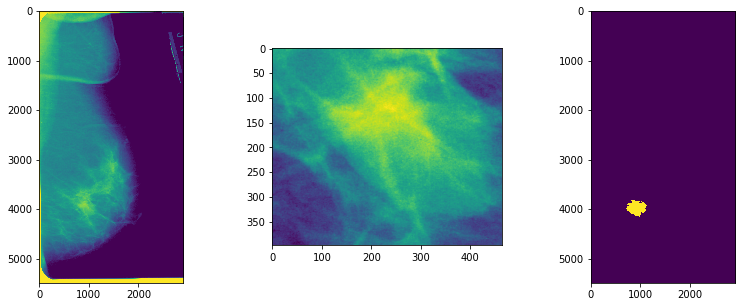

In [53]:
arrs = get_arrays_per_row(4, df=train_mass)
plot_files(arrs)

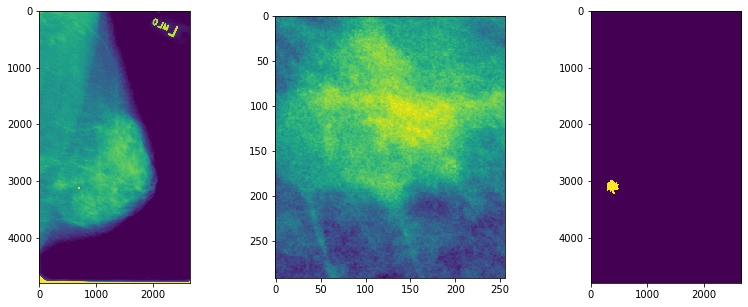

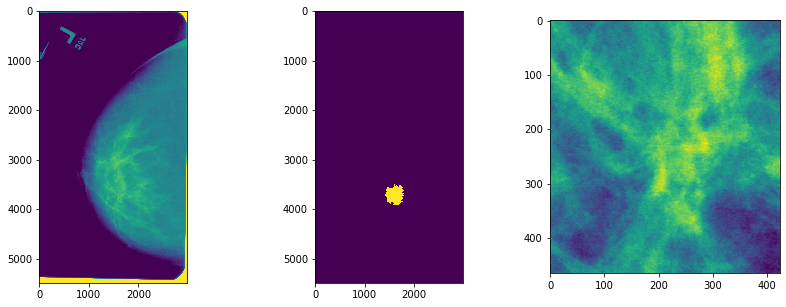

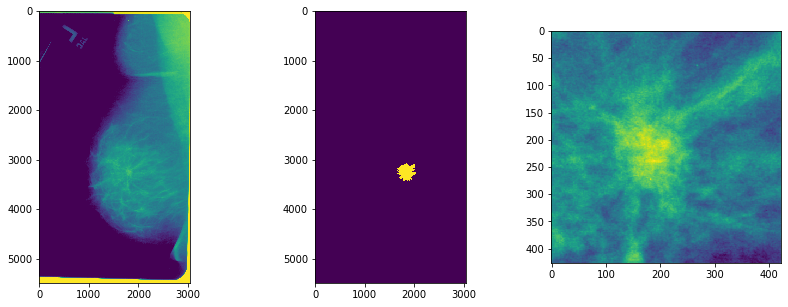

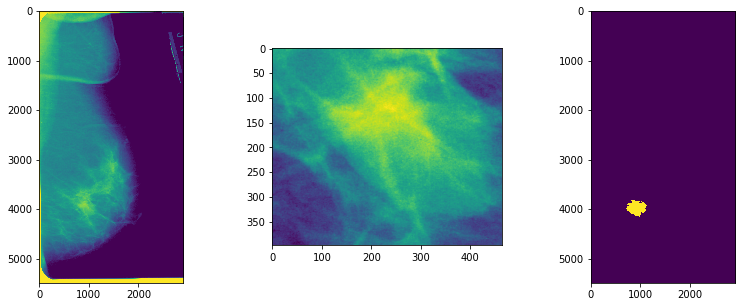

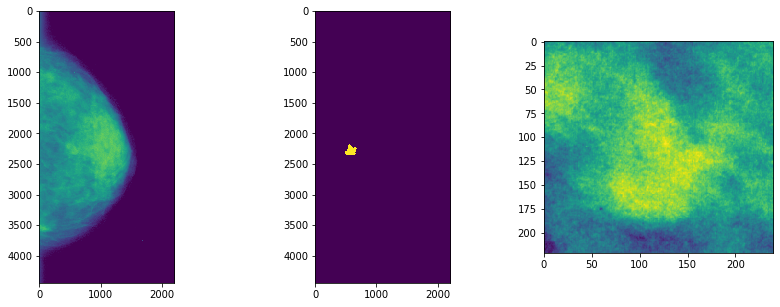

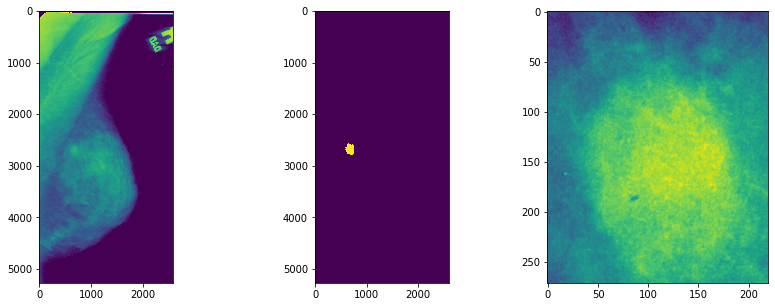

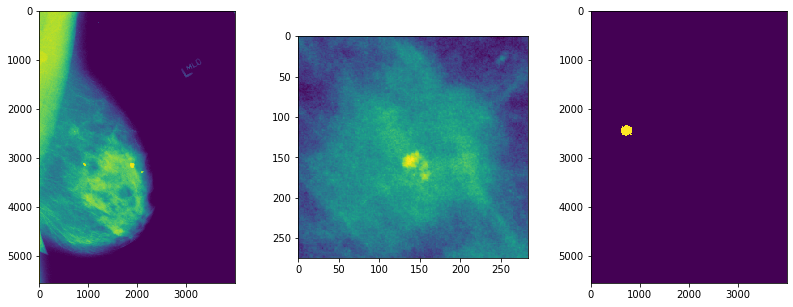

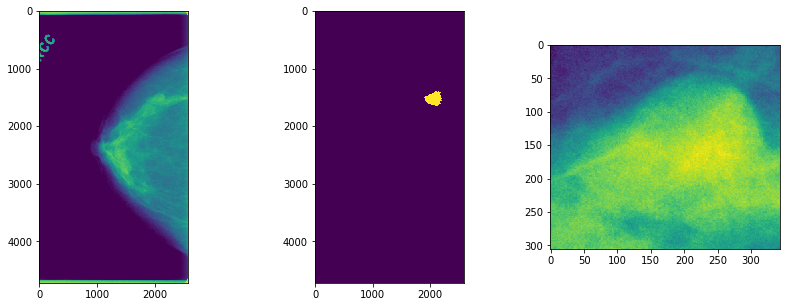

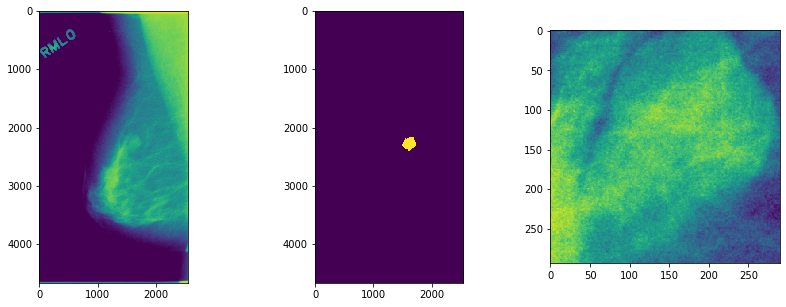

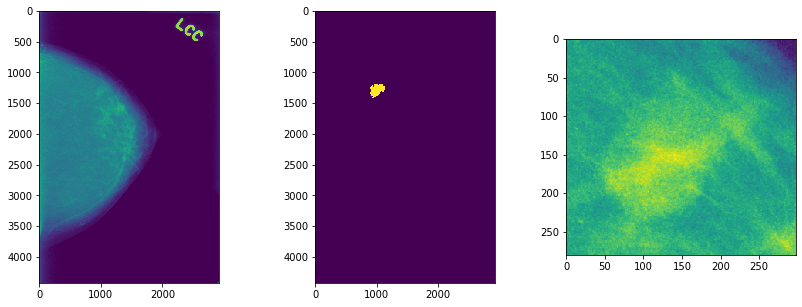

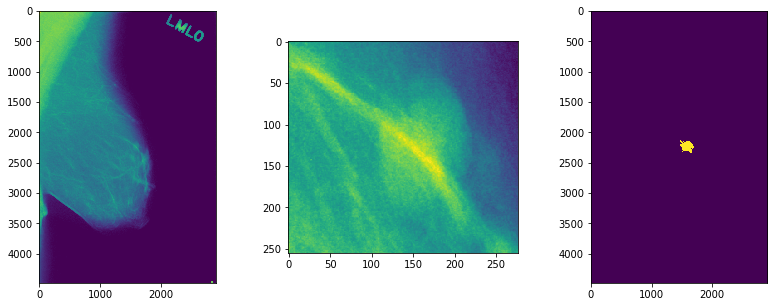

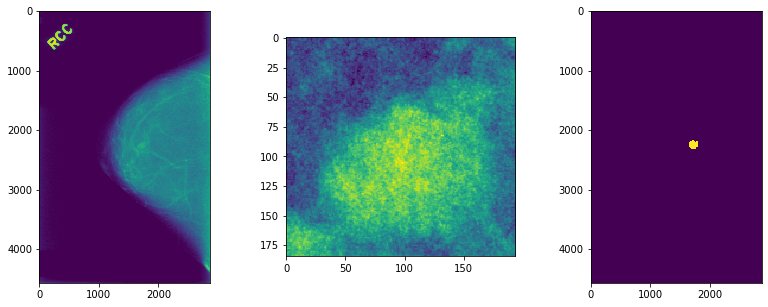

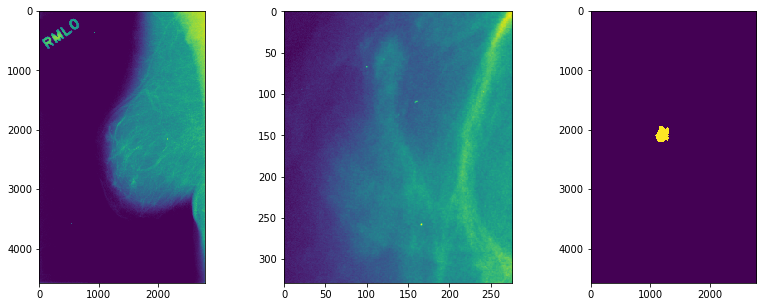

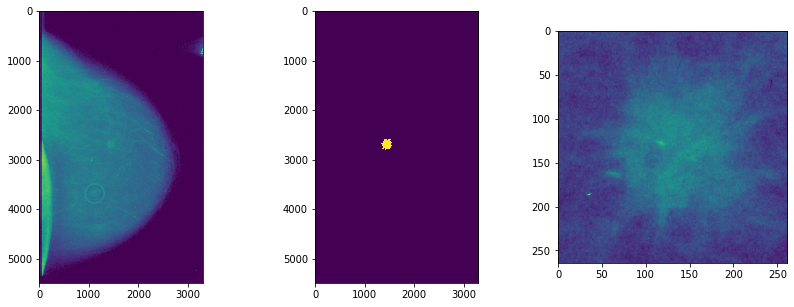

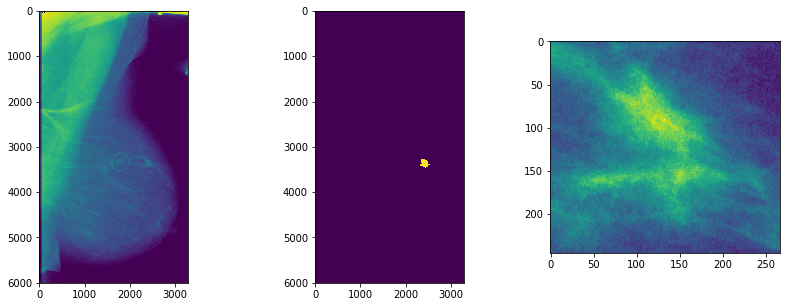

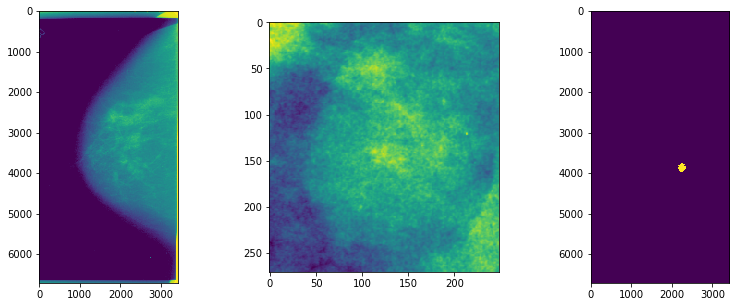

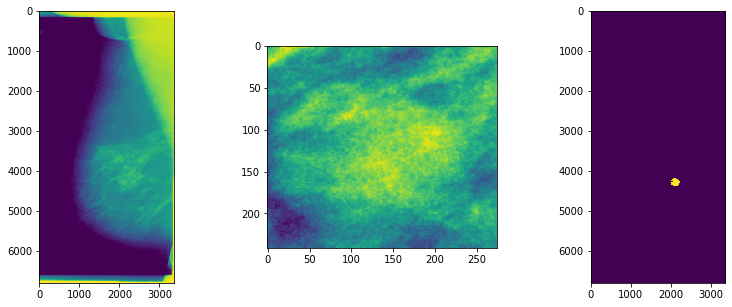

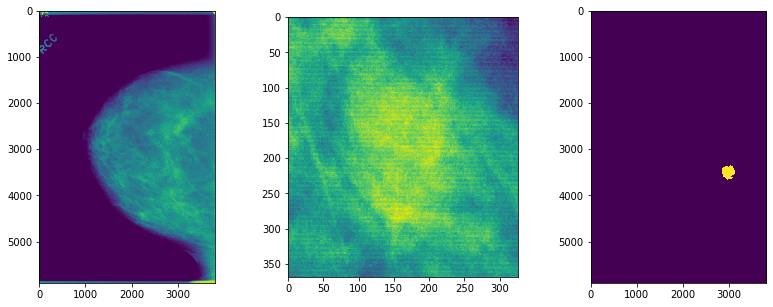

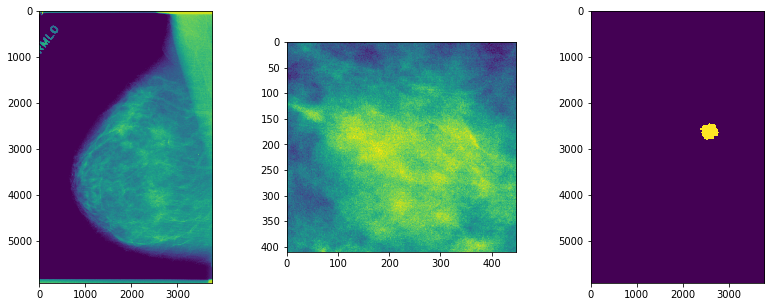

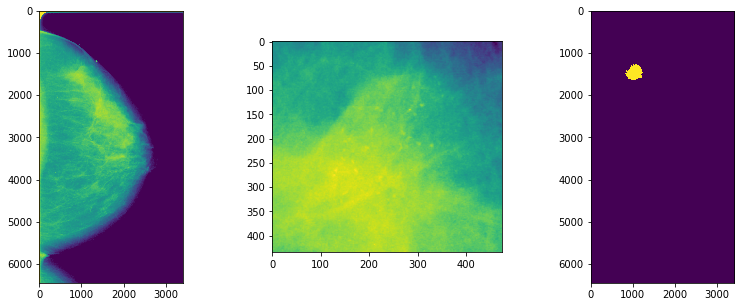

In [51]:
for i in range(1,21):
    arrs = get_arrays_per_row(i, df=train_mass)
    plot_files(arrs)